In [1]:
import pandas as pd

df = pd.read_csv(
    "./dataset/adult/adult.csv",
    sep=",",
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "Income",
    ],
)

# Drop rows with missing values
df.replace(" ?", pd.NA, inplace=True)
df.dropna(inplace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_encoders = {}
for column in df.select_dtypes(include=["object"]).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

X = df.drop("Income", axis=1).values
y = df["Income"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [3]:
from typing import Any

from torch import Tensor, nn


class IncomeClassifier(nn.Module):
    def __init__(
        self,
        input_dim: int,
        num_hidden_layers: int = 1,
        hidden_dim: int = 32,
        dropout: float = 0,
        activation_fn: Any = nn.ReLU,
    ) -> None:
        super(IncomeClassifier, self).__init__()

        layers = [nn.Linear(input_dim, hidden_dim), activation_fn()]

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_fn())

        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.model(x))

In [4]:
from tqdm import tqdm


def train_model(
    num_hidden_layers: int,
    num_epochs: int = 10,
    batch_size: int = 64,
    dropout: float = 0,
    activation_fn: Any = nn.ReLU,
):
    # Data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    # Setup model, loss, optimizer
    model = IncomeClassifier(
        input_dim=X_train.shape[1],
        num_hidden_layers=num_hidden_layers,
        dropout=dropout,
        activation_fn=activation_fn,
    )
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, train_accuracies, grad_norms = [], [], []
    val_losses, val_accuracies = [], []

    epoch_grad_norm = 0
    num_batches = 0

    # Start Train
    for epoch in tqdm(range(num_epochs)):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()

            outputs = model(batch_x)
            batch_y = batch_y.unsqueeze(1)  # Ensure shape compatibility

            loss = criterion(outputs, batch_y)

            loss.backward()
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)  # L2 norm
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm**0.5
            epoch_grad_norm += total_norm
            num_batches += 1

            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy for the batch
            predictions = (outputs >= 0.5).float()
            correct_predictions += (predictions == batch_y).sum().item()
            total_predictions += batch_y.size(0)

        # Calculate average loss and accuracy for the epoch
        average_loss = epoch_loss / len(X_train)
        accuracy = correct_predictions / total_predictions
        avg_grad_norm = epoch_grad_norm / num_batches

        train_losses.append(average_loss)
        train_accuracies.append(accuracy)
        grad_norms.append(avg_grad_norm)

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.unsqueeze(1))
            val_predictions = (val_outputs >= 0.5).float()
            val_accuracy = (val_predictions == y_val.unsqueeze(1)).sum().item() / len(
                y_val
            )

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return train_losses, train_accuracies, grad_norms, val_losses, val_accuracies

In [5]:
# TODO: change
num_epochs = 10

# TODO: change
layer_configs = [1, 3, 5, 9, 20, 50, 500]
results = {}

results = {}
for num_hidden_layers in layer_configs:
    print(f"\nTraining model with {num_hidden_layers} hidden layer(s)")
    train_losses, train_accuracies, grad_norms, val_losses, val_accuracies = (
        train_model(num_hidden_layers, num_epochs)
    )
    results[num_hidden_layers] = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "grad_norms": grad_norms,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }


Training model with 1 hidden layer(s)


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



Training model with 3 hidden layer(s)


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]



Training model with 5 hidden layer(s)


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]



Training model with 9 hidden layer(s)


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]



Training model with 20 hidden layer(s)


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



Training model with 50 hidden layer(s)


100%|██████████| 10/10 [00:34<00:00,  3.40s/it]



Training model with 500 hidden layer(s)


100%|██████████| 10/10 [05:57<00:00, 35.78s/it]


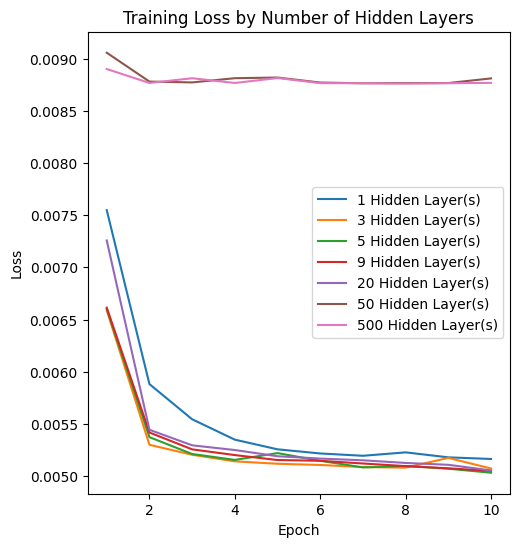

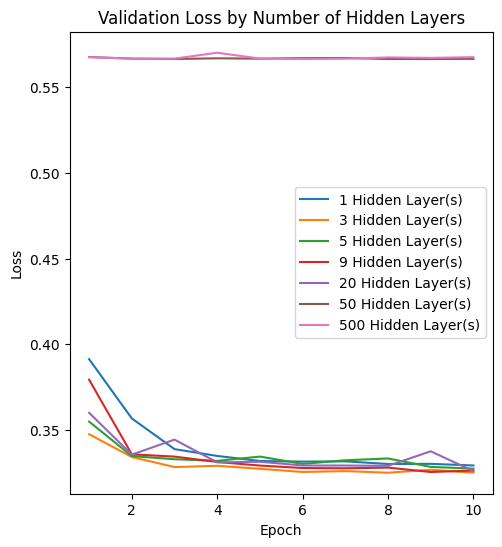

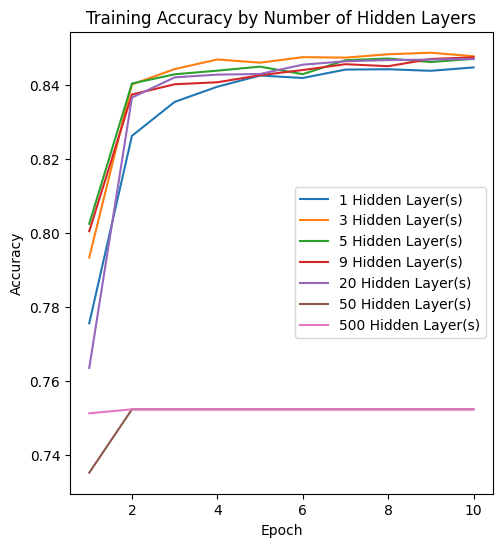

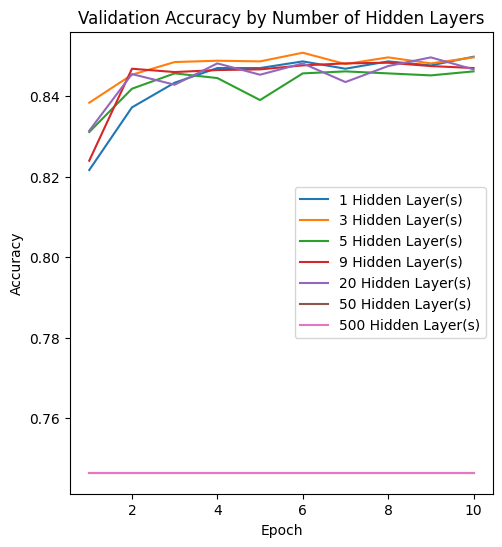

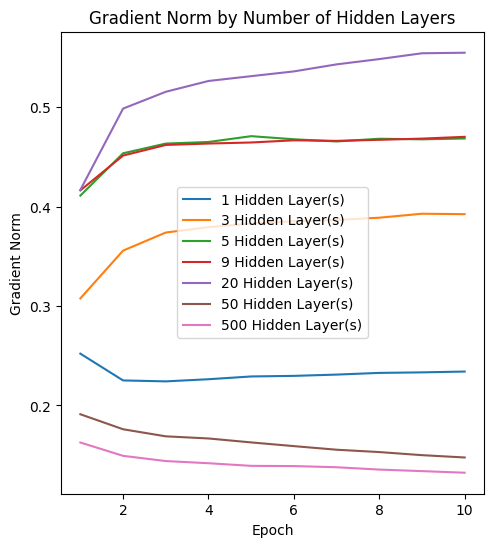

In [6]:
from matplotlib import pyplot as plt


def plot_result(results, metric, ylabel, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for num_hidden_layers, metrics in results.items():
        plt.plot(
            range(1, num_epochs + 1),
            metrics[metric],
            label=f"{num_hidden_layers} Hidden Layer(s)",
        )
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()


plot_result(results, "train_losses", "Loss", "Training Loss by Number of Hidden Layers")
plot_result(results, "val_losses", "Loss", "Validation Loss by Number of Hidden Layers")
plot_result(
    results,
    "train_accuracies",
    "Accuracy",
    "Training Accuracy by Number of Hidden Layers",
)
plot_result(
    results,
    "val_accuracies",
    "Accuracy",
    "Validation Accuracy by Number of Hidden Layers",
)
plot_result(
    results, "grad_norms", "Gradient Norm", "Gradient Norm by Number of Hidden Layers"
)

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]
/tmp/ipykernel_76845/3825929991.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


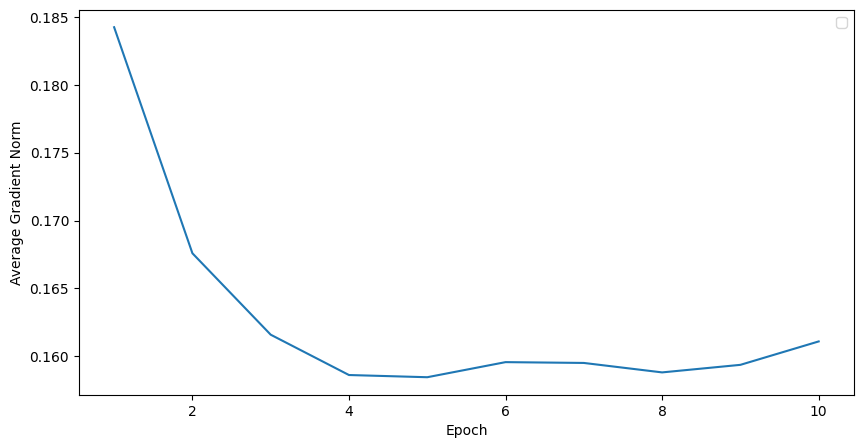

In [7]:
# attempt to make vanish gradient
# TODO: change
n_epochs = 10
train_losses, train_accuracies, grad_norms, val_losses, val_accuracies = train_model(
    3, n_epochs, activation_fn=nn.Sigmoid
)
plt.figure(figsize=(10, 5))

plt.plot(range(1, n_epochs + 1), grad_norms)

plt.xlabel("Epoch")
plt.ylabel("Average Gradient Norm")
plt.legend()

In [8]:
# Cross-validation

from sklearn.model_selection import KFold


def cross_validate_model(
    num_hidden_layers: int,
    num_epochs: int = 10,
    batch_size: int = 64,
    dropout: float = 0,
    activation_fn: Any = nn.ReLU,
):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    total_val_losses, total_val_accuracies = 0, 0

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.float32)

        # Setup model, loss, optimizer
        train_losses, train_accuracies, grad_norms, val_losses, val_accuracies = (
            train_model(
                num_hidden_layers=num_hidden_layers,
                num_epochs=num_epochs,
                batch_size=batch_size,
                dropout=dropout,
                activation_fn=activation_fn,
            )
        )

        total_val_losses += val_losses[-1]
        total_val_accuracies += val_accuracies[-1]

    avg_val_loss = total_val_losses / 5
    avg_val_accuracy = total_val_accuracies / 5
    return avg_val_loss, avg_val_accuracy


Cross-validating model with 1 hidden layer(s)


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Average Validation Loss: 0.3299
Average Validation Accuracy: 0.8485

Cross-validating model with 3 hidden layer(s)


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Average Validation Loss: 0.3277
Average Validation Accuracy: 0.8470

Cross-validating model with 5 hidden layer(s)


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Average Validation Loss: 0.3269
Average Validation Accuracy: 0.8475

Cross-validating model with 9 hidden layer(s)


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Average Validation Loss: 0.3276
Average Validation Accuracy: 0.8456

Cross-validating model with 20 hidden layer(s)


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Average Validation Loss: 0.3344
Average Validation Accuracy: 0.8459

Cross-validating model with 50 hidden layer(s)


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


Average Validation Loss: 0.5670
Average Validation Accuracy: 0.7464

Cross-validating model with 500 hidden layer(s)


100%|██████████| 10/10 [06:15<00:00, 37.60s/it]

Average Validation Loss: 0.5669
Average Validation Accuracy: 0.7464


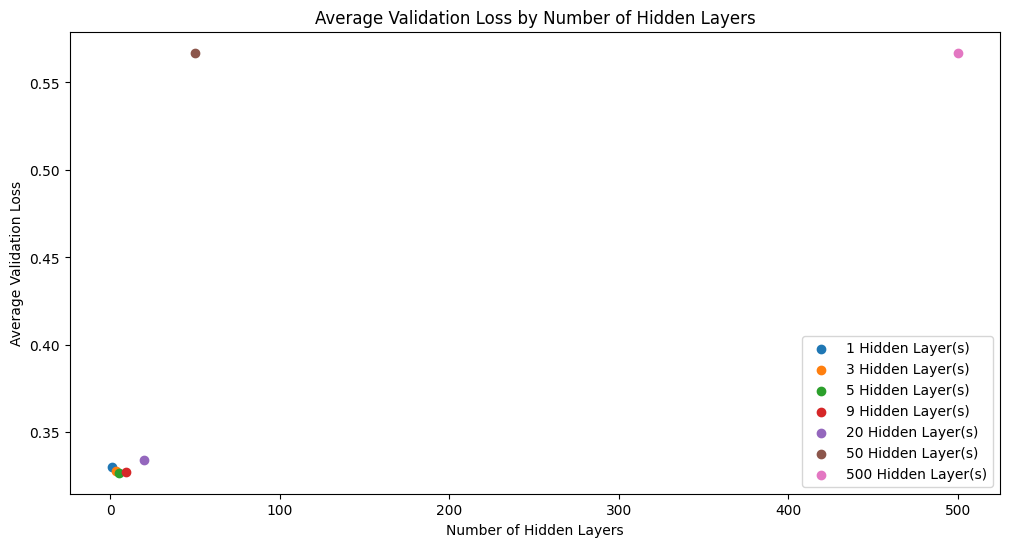

In [9]:
plt.figure(figsize=(12, 6))

for num_hidden_layers in layer_configs:
    print(f"\nCross-validating model with {num_hidden_layers} hidden layer(s)")
    avg_val_loss, avg_val_accuracy = cross_validate_model(num_hidden_layers, num_epochs)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

    plt.scatter(
        num_hidden_layers, avg_val_loss, label=f"{num_hidden_layers} Hidden Layer(s)"
    )
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Average Validation Loss")
plt.title("Average Validation Loss by Number of Hidden Layers")
plt.legend()